# **Named Entity Identification (NEI) using SVM**

In [ ]:
! pip install -q datasets

In [ ]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from tqdm.notebook import tqdm
from datasets import load_dataset
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [ ]:
D = 6 # number of features used
SW = stopwords.words("english")
PUNCT = list(punctuation)

In [ ]:
def prepare_data(data):
  words = [] # stores the str
  features = [] # feature array, one vector per word in the corpus
  labels = [] # labels (0/1)

  for d in tqdm(data):

    tokens = d["tokens"]
    tags = d["ner_tags"]

    l = len(tokens)
    for i in range(l):

      x = vectorize(w = tokens[i], scaled_position = (i/l))

      if tags[i] > 0:
          y = 1
      else:
          y = 0

      features.append(x)
      labels.append(y)

    words += tokens

  words = np.asarray(words, dtype = "object")
  features = np.asarray(features, dtype = np.float32)
  labels = np.asarray(labels, dtype = np.float32)

  return words, features, labels

def vectorize(w, scaled_position):
  # w - str : a token

  if w[0].isupper():    # if first character is upper
    title = 1
  else:
    title = 0

  if w.isupper():       # if all the characters are upper
    allcaps = 1
  else:
    allcaps = 0

  if w.lower() in SW:   # if the word is a stopword
    stopword = 1
  else:
    stopword = 0

  if w in PUNCT:      # is punctuation
    punct = 1
  else:
    punct = 0

  v = np.zeros(D).astype(np.float32)

  v[0] = title
  v[1] = allcaps
  v[2] = stopword
  v[3] = punct
  v[4] = scaled_position
  v[5] = len(w)

  return v




In [ ]:
D = 9  # Update this number to reflect the new total features (previously 6 + 3 new features)

def vectorize(w, scaled_position):
    # Original features
    title = 1 if w[0].isupper() else 0
    allcaps = 1 if w.isupper() else 0
    stopword = 1 if w.lower() in SW else 0
    punct = 1 if w in PUNCT else 0

    # New features
    is_digit = 1 if w.isdigit() else 0
    contains_hyphen = 1 if '-' in w else 0
    is_alphanumeric = 1 if w.isalnum() else 0

    v = np.zeros(D).astype(np.float32)

    # Assigning values to the vector
    v[0] = title
    v[1] = allcaps
    v[2] = stopword
    v[3] = punct
    v[4] = scaled_position
    v[5] = len(w)

    # New features in the vector
    v[6] = is_digit
    v[7] = contains_hyphen
    v[8] = is_alphanumeric

    return v


In [ ]:
def infer(model,scaler, s):
  tokens = word_tokenize(s)
  features = []

  l = len(tokens)

  for i in range(l):
    f = vectorize(w = tokens[i], scaled_position = (i/l))
    features.append(f)

  features = np.asarray(features,dtype = np.float32)
  scaled = scaler.transform(features)

  pred = model.predict(scaled)

  return pred, tokens, features




In [ ]:
data = load_dataset("conll2003")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:

data = load_dataset("conll2003") # of type datasets.dataset_dict.DatasetDict
data_train = data["train"] # 14,041 rows (type: datasets.arrow_dataset.Dataset)
data_val   = data["validation"] # 3250 rows
data_test  = data["test"] # 3453 rows

# columns: 'id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'

In [ ]:
words_train, X_train, y_train = prepare_data(data_train)
words_val, X_val, y_val       = prepare_data(data_val)
words_test, X_test, y_test    = prepare_data(data_test)

  0%|          | 0/14041 [00:00<?, ?it/s]

  0%|          | 0/3250 [00:00<?, ?it/s]

  0%|          | 0/3453 [00:00<?, ?it/s]

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(203621, 6)
(51362, 6)
(46435, 6)


In [ ]:
# Print some examples of named entities in y_val
nes = words_val[y_val == 1]
for ne in np.random.choice(nes, size = 15):
    print(ne)

OAKLAND
Heli
Pierce
Parnevik
Bellamore
Chester
Newsroom
Street
Carlos
Sri
U.S.
Iraq
Albany
Zinzan
Mansfield


In [ ]:
# Standardize the features such that all features contribute equally to the distance metric computation of the SVM
scaler = StandardScaler()

# Fit only on the training data (i.e. compute mean and std)
scaler = scaler.fit(X_train)

# Use the train data fit values to scale val and test
X_train = scaler.transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

In [ ]:
model = SVC(C = 1.0, kernel = "linear", class_weight = "balanced", random_state = SEED, verbose = True)
model.fit(X_train, y_train)

[LibSVM]

SVC(class_weight='balanced', kernel='linear', verbose=True)

In [ ]:
y_pred_val = model.predict(X_val)

In [ ]:
print(classification_report(y_true = y_val, y_pred = y_pred_val))

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     42759
         1.0       0.82      0.97      0.89      8603

    accuracy                           0.96     51362
   macro avg       0.91      0.96      0.93     51362
weighted avg       0.96      0.96      0.96     51362



Accuracy: 0.9593
Precision: 0.8202
Recall: 0.9694
F1 Score: 0.8886


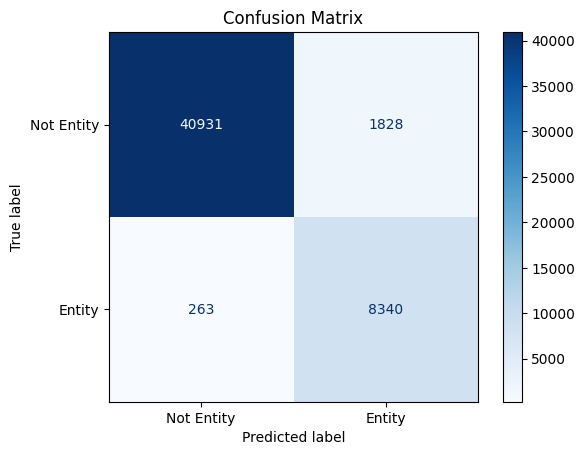

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the test set
y_pred_test = model.predict(X_val)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score( y_val, y_pred_test)
precision = precision_score( y_val, y_pred_test)
recall = recall_score( y_val, y_pred_test)
f1 = f1_score( y_val, y_pred_test)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot the confusion matrix
cm = confusion_matrix( y_val, y_pred_test, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Entity", "Entity"])
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()


In [ ]:
# A few examples

examples = [
    "Delhi is the capital of India.",
    "US Vice President Kamala Harris, PM Modi talk up Indo-US ties at 1st in-person meeting.",
    "Covid-19 India Live News: National Task Force drops Ivermectin, HCQ drugs from Covid-19 treatment protocol; India logs 31,382 new cases.",
    "US Rules Out Adding India Or Japan To Security Alliance With Australia And UK" # all words are capitalized
]

for e in examples:
    pred, tokens, features = infer(model, scaler, e)
    annotated = []
    for w, p in zip(tokens, pred):
        annotated.append(f"{w}_{int(p)}")
    print(" ".join(annotated))
    print()

Delhi_1 is_0 the_0 capital_0 of_0 India_1 ._0

US_1 Vice_1 President_1 Kamala_1 Harris_1 ,_0 PM_1 Modi_1 talk_0 up_0 Indo-US_1 ties_0 at_0 1st_0 in-person_0 meeting_0 ._0

Covid-19_1 India_1 Live_1 News_1 :_0 National_1 Task_1 Force_1 drops_0 Ivermectin_1 ,_0 HCQ_1 drugs_0 from_0 Covid-19_1 treatment_0 protocol_0 ;_0 India_1 logs_0 31,382_0 new_0 cases_0 ._0

US_1 Rules_1 Out_0 Adding_1 India_1 Or_0 Japan_1 To_0 Security_1 Alliance_1 With_0 Australia_1 And_0 UK_1



In [ ]:
pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.1 MB/s eta 0:00:00


In [ ]:
import gradio as gr

def predict_entities(sentence):
    # Get predictions for the sentence
    pred, tokens, features = infer(model, scaler, sentence)

    # Format the output with tokens and their predicted labels
    annotated = [f"{w}_{'1' if int(p) == 1 else '0'}" for w, p in zip(tokens, pred)]

    # Return the formatted result as a string
    return " ".join(annotated)

# Define the Gradio interface
interface = gr.Interface(
    fn=predict_entities,
    inputs=gr.Textbox(lines=2, placeholder="Enter a sentence to predict named entities..."),
    outputs=gr.Textbox(lines=5, label="Named Entities"),
    title="Named Entity Recognition with SVM",
    description="Type a sentence to see which words are identified as named entities."
)

# Launch the Gradio interface
interface.launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8b5265146406097201.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
